In [1]:
# Name Dipika Sharma
# DSC 530 T301 Data Exploration
# Week 11

# Assignment 11.2 - (13.1)

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [21]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/mj-clean.csv")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dat.gz"
)
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py"
)
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/survival.py")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct"
)
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz"
)

Downloaded 2006_2010_FemRespSetup.dct
Downloaded 2006_2010_FemResp.dat.gz


In [22]:
import numpy as np
import pandas as pd

import random

import thinkstats2
import thinkplot
import nsfg
import survival

# Exercise 13.1

In NSFG Cycles 6 and 7, the variable cmdivorcx contains
the date of divorce for the respondent’s first marriage, if applicable, encoded
in century-months.
Compute the duration of marriages that have ended in divorce, and the
duration, so far, of marriages that are ongoing. Estimate the hazard and
survival curve for the duration of marriage.
Use resampling to take into account sampling weights, and plot data from
several resamples to visualize sampling error.
Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [25]:
# Lets read the respondent data.

resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

In [26]:
# Defining the function to cleans the respondent data, this function will take the dataframe, process the dataset with cleaning steps.
def CleanData(resp):
    
    # Read the respondent file and replace invalid values of cmdivorcx
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)
    
    # Lets compute each respondent’s marriage duration that have ended in divorse, duration so far and not divorsed.
    resp["notdivorced"] = resp.cmdivorcx.isnull().astype(int)
    resp["duration"] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp["durationsofar"] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime("1899-12-15")
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [27]:
# Lets call the cleaning function for respondent 2002 data.
# evrmarry is 1 if the respondent had been married prior to the date of interview, 0 otherwise.
CleanData(resp6)
married6 = resp6[resp6.evrmarry == 1]

# Lets call the cleaning function for respondent 2010 data.
# evrmarry is 1 if the respondent had been married prior to the date of interview, 0 otherwise.
CleanData(resp7)
married7 = resp7[resp7.evrmarry == 1]

In [28]:
# Defining function to plot divorse curves on resampling data. This function is taking respondent dataframe list as an input.

def ResampleDivorceCurve(resps):

    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color="#225EA8", alpha=0.1)

    thinkplot.Show(xlabel="years", axis=[0, 28, 0, 1])

In [29]:
# Defining function to plot a curve on divorse data for each birth cohort.
# resps is an input of the function which is list of respondent dataframe.


def ResampleDivorceCurveByDecade(resps):

    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel="Years", ylabel="Fraction undivorced", axis=[0, 28, 0, 1])

In [30]:
# Defining the function to plot survival curves of respondent data grouo by decades.


def EstimateSurvivalByDecade(groups, **options):
 
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

In [31]:
# Defining the function which takes respondent dataframe as an input and estimate the survival curves.
# This function will returns the Hazard and survival function.

def EstimateSurvival(resp):
    # storing the not divorsed and divorsed respondent in different variables.
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()
    
    # Calculating Hazard function.
    hf = survival.EstimateHazardFunction(complete, ongoing)
    # Survival function
    sf = hf.MakeSurvival()

    return hf, sf

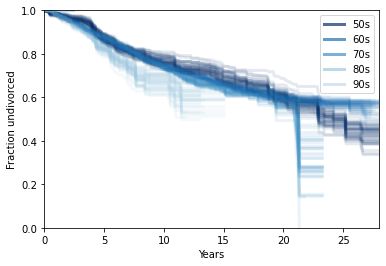

In [33]:
# Once the data is cleaned let see how the curves comes out for respondent of 2002 and 2010 which are married prior to the date of interview.

ResampleDivorceCurveByDecade([married6, married7])

#### Lets check the above Survival curves for respondents born during different decades.
#### As we can see the womens born in 50s have completed most years of their marriage and most of them never get divorsed where as the womens who are borns in 80s or 90s have completed only 10 to 15 years of their marriage.
#### We also see that womens born in 60s or 70s either completed 22 years of marriage or are still married.